# Hoja de Trabajo 4

Instrucciones: A continuación verá una lista de ejercicios que debe completar para poder entregar la hoja de trabajo 4.

## Problema Único

1. Descargue el dataset de trabajo, el cual contiene aproximadamente 800,000 tweets de diversos temas.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import spacy 
import re

# Comando para instalar WordCloud (Una vez se descargó la wheel correspondiente .whl)
# pip install wordcloud-1.8.1-cp39-cp39-win_amd64.whl
from wordcloud import WordCloud

# Se carga el modelo de lenguaje (Inglés Mediano)
# Correr esto antes para bajar el modelo de lenguaje: python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

# Se cargan los datos
# Dado que la tabla no cuenta con encabezado, se le coloca uno utilizando una lista
raw_dataset = pd.read_csv("tweets.csv", header=None, names=["No", "ID", "Timestamp", "Query", "User", "Content"])

# Se despliega una muestra de los datos
raw_dataset.head()

,No,ID,Timestamp,Query,User,Content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


2. Usando expresiones regulares, determine los 3 usuarios más populares dentro del dataset. Luego arme un corpus el cual contenga los siguientes elementos por cada uno de los 3 usuarios seleccionados:

    - Content: Texto del tweet
    - ID: ID del tweet. Si el tweet no posee ID entonces deberá colocar el string "Undefined".
    - Timestamp
    - Largo del Tweet

    Recuerde que un corpus es una tabla o dataframe, el cual contiene un conjunto de documentos y metadata sobre dichos documentos en formato tabular. Note que deberá terminar con tres dataframes diferentes.

In [2]:
# Explicación REGEX:
# - Se revisa que antes del @ del usuario exista uno de dos elementos (?<=):
#   - El inicio del string (^)
#   - El inicio del string seguido de caracteres numéricos, letras, "." o "_" (?<=[^a-zA-Z0-9-\.])
# - Match del caracter "@"
# - Match de letras, números o "_" de cero a ilimitadas veces ([A-Za-z0-9_]+)
regex_user = r"(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)"

# Se extraen todos los users encontrados en "Content" utilizando el regex
users_table = raw_dataset["Content"].str.extractall(regex_user)

# 1. Se extrae la tabla "0" de la tabla de usuarios.
# 2. De dicha tabla se utilizan todas las filas de la tercera columna (usuarios)
# 3. Se convierte dicha columna a una lista de python
users_list = users_table[0].values.tolist()

# Se cuenta el número de apariciones de cada usuario
users_count = Counter(users_list)

# Se extraen los 3 usuarios más comunes
users_top_count = users_count.most_common(3)

# 1. Se convierte la lista de tuplas "users_top" en un array de numpy
# 2. Se extrae la primera columna del array de numpy (nombre de usuarios)
# 3. Se convierte el array en una lista
top_users = list(np.array(users_top_count)[:,0])

# Se imprimen los 3 usuarios más "mencionados" y el número de veces que fueron mencionados
print(users_top_count)

[('mileycyrus', 4494), ('tommcfly', 3883), ('ddlovato', 3465)]


In [3]:
# Se crea un diccionario vacío para los 3 "corpuses"
corpus = {}

# Para cada usuario en los usuarios "top"
for user in top_users:

    # Se crea un nuevo regex para cada usuario
    regex = r"(?<=^|(?<=[^a-zA-Z0-9-\.]))@(" + user + r"+)"

    # Se guarda el corpus del "top user" especificado
    # 1. Se extrae la columna de "Content" del dataset
    # 2. Se revisa que filas del dicha columna contienen el regex especificado
    # 3. Las filas que contienen el regex son extraídas del "raw_dataset" y guardadas en el corpus correspondiente
    corpus[user] = raw_dataset.loc[raw_dataset["Content"].str.contains(regex), :]

    # Se eliminan las columnas de "No", "Query" y "User"
    corpus[user] = corpus[user].drop(["No", "Query", "User"], axis = 1)

    # Se resetean los índices de fila de la tabla
    corpus[user] = corpus[user].reset_index(drop = True)

    # Se cuenta el número de caracteres en la columna de "Content" y se agrega a una nueva columna
    corpus[user]["Length"] = corpus[user]["Content"].str.len()


C:\Users\eddys\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


3. Posterior a tener sus 3 corpus creados, responda: ¿Cuál es la razón por la que citan a ese usuario? Para esto es necesario que extraiga el contexto de cada tweet y verifique cuales son las palabras que más rodean al nombre de usuario. Recomendamos utilizar un modelo "bag of words", en el cual se seleccionen de 10 a 20 palabras representativas de cada corpus. Para extraer un contexto válido y debido a la naturaleza del tipo de datos que están disponibles en nuestro dataset, es necesario que realice el flujo de pre-procesamiento visto en clase, esto es:

    - Normalización de texto
    - Tokenización
    - Remover "stopwords"
    - Stemming y Lemmatization

In [4]:
# Se crea un diccionario vacío para las palabras extraídas para cada usuario
content_words = {}

# Para cada usuario en el top 3
for top_user in top_users:

    # Se extrae el contenido de los tweets
    content = corpus[top_user]["Content"]

    # ============================
    # NORMALIZACIÓN DE TEXTO
    # ============================

    # Se eliminan las menciones del usuario como tal
    regex_topUser = r"(?<=^|(?<=[^a-zA-Z0-9-\.]))@(" + top_user + r"+)"
    content = content.replace(regex_topUser, '', regex = True)

    # Se retiran todos los caracteres que no están listados entre corchetes
    content = content.replace(r"[^a-zA-Z0-9\s{1}áéíóúüñÁÉÍÓÚ']", '', regex = True)

    # Se colocan todas las letras en minúsculas
    content = content.str.lower()

    # Se eliminan "enters"
    content = content.replace(r'\\n','', regex=True) 
    content = content.replace(r'\\r\\n','', regex=True) 

    # ============================
    # TOKENIZACIÓN
    # ============================

    # Se aplica tokenización a todas las filas de contenido
    content_tokens = content.apply(lambda x: nlp(x))

    # ============================
    # STOPWORDS Y LEMMATIZATION
    # ============================

    # Función para eliminar stopwords
    def removeStopsAndLemmatize(doc):
        # Se hace stemming y lemmatization de los tokens
        return [token.lemma_ for token in doc if not token.is_stop]

    # Se eliminan las stop words
    content_lemma = list(map(removeStopsAndLemmatize, content_tokens))

    # ============================
    # POST-PROCESADO
    # ============================

    # Se aplana la lista de listas obtenida luego de la lemmatización
    proc_content = [item for sublist in content_lemma for item in sublist]

    # Se eliminan todas las palabras con menos de 3 letras
    proc_content = [word for word in proc_content if not len(word) < 3]

    # Se convierte la lista de palabras en un solo string separado por espacios
    content_string = " ".join(proc_content)

    # Se cuenta el número de apariciones de cada palabra
    word_count = Counter(proc_content)

    # Se extraen las 20 palabras más comunes
    top_word_count = word_count.most_common(20)

    # Se guarda el texto procesado en el diccionario de palabras
    content_words[top_user] = [content_string, top_word_count]


4. Finalmente, cree un "Word Cloud" por cada ID de twitter seleccionado. Note que dado que se seleccionaron 3 usuarios, deberá graficar 3 "Word Clouds". 

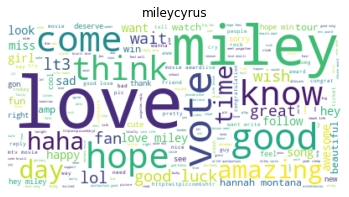

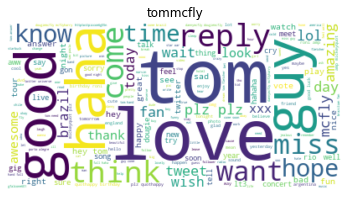

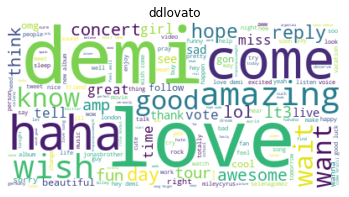

In [5]:
for top_user in top_users:

    # Se extraen las palabras procesadas en la forma de un string
    content_string = content_words[top_user][0]

    # Se crean los gráficos del wordcloud
    word_cloud = WordCloud(background_color = "white").generate(content_string)

    # Se grafica el wordcloud en la forma de una imagen
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.title(top_user)
    plt.axis("off")
    plt.show()

## Conclusiones

Luego de analizar los resultados obtenidos, se pudo llegar a determinar que la razón primordial por la que estos tres usuarios destacaron entre los demás, es porque los mismos consisten de celebridades altamente activas en Twitter (Demi Lovato, Miley Cyrus y Tom Fletcher). En su mayoría, las palabras que destacan entre los tweets son los nombres de las celebridades (tom, demi o miley) y halagos a la persona por parte de sus fans, así como palabras relacionadas a los "tours" o "conciertos" de las mismas. También parece bastante interesante que la palabra "vote" haya destacado tanto entre los tweets que mencionan a Miley Cyrus. Talvez se debe a que la misma ha comenzado a introducir contenido un poco más "político" en sus tweets, aunque también se puede deber a algún tipo de votación realizada entre fans en un poll creado por ella.
